<a href="https://colab.research.google.com/github/Aditya9015/demo/blob/main/ADI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After SMOTE - X shape: (294, 22) y shape: (294,)
After PCA shape: (294, 8) | Number of components: 8
Fitting 10 folds for each of 32 candidates, totalling 320 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:50:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.9864864864864865
Precision: 0.9743589743589743
Recall: 1.0
F1 Score: 0.987012987012987


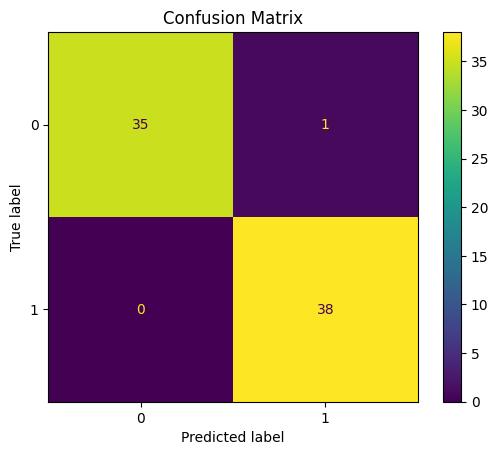

In [16]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 1. Load data
url_string = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
url_content = requests.get(url_string).content
with open('data.csv', 'wb') as data_file:
    data_file.write(url_content)

df = pd.read_csv('data.csv')

X = df.drop(['name', 'status'], axis=1)
y = df['status']

# 2. Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply SMOTE before PCA
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
print("After SMOTE - X shape:", X_resampled.shape, "y shape:", y_resampled.shape)

# 4. Apply PCA after SMOTE
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_resampled)
print(f"After PCA shape: {X_pca.shape} | Number of components: {pca.n_components_}")

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled, test_size=0.25, random_state=42)

# 6. XGBoost model and GridSearch
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=10, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# 7. Evaluate
best_model = grid_xgb.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()
